<a href="https://colab.research.google.com/github/lindsay99m/GEO-558-Unsupervised/blob/main/lmoller_finalunsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I will be using earthquake data from the Northern California Earthquake Data Center. This data contains information on
magnitude, depth, time, date, location, etc. for earthquakes in Northern California. I will use this data to attempt to determine if there is a
correlation between earthquake magnitude, depth, and intervals between earthquakes. I am using data from the year 2019. The dataset is localized to a fairly small area which will hoepfully make it easier to determine if there is a correlation between the recorded earthquake data. This is important information to correlate as earthquakes can cause a lot of human and economic loss. If areas where earthquakes are common are better able to prepare for earthquakes or are better able to determine when/how strong earthquakes will be then the amount of human and economic loss can be lowered.

# Pre-processing

In [146]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
url = 'https://raw.githubusercontent.com/lindsay99m/GEO-558-Unsupervised/28447ca67b5a8a892d53c2c73f39454284926fdd/NCEDCdata.csv'
data = pd.read_csv(url)
data.describe()

,Lat,Lon,Depth,Mag,Nst,Gap,Clo,RMS,Event ID
count,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2799.000000,2.799000e+03
mean,37.226104,-119.995539,6.486720,2.512176,30.489461,119.868882,14.202572,0.131597,7.322216e+07
std,1.649315,2.318310,7.328887,0.445542,26.466518,67.518041,17.008724,0.158346,1.313775e+05
min,34.519330,-125.910160,-2.250000,2.000000,4.000000,16.000000,0.000000,0.000000,7.111009e+07
25%,36.089670,-122.009750,1.690000,2.190000,9.000000,69.000000,3.000000,0.060000,7.318831e+07
50%,36.431000,-118.874500,4.750000,2.410000,23.000000,104.000000,9.000000,0.090000,7.322798e+07
75%,38.757000,-117.890500,8.750000,2.700000,45.000000,159.000000,19.000000,0.140000,7.327119e+07
max,41.891170,-117.760170,55.650000,5.580000,245.000000,352.000000,160.000000,2.580000,7.332190e+07


In [147]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2799 non-null   object 
 1   Time           2799 non-null   object 
 2        Lat       2799 non-null   float64
 3          Lon     2799 non-null   float64
 4    Depth         2799 non-null   float64
 5    Mag           2799 non-null   float64
 6   Magt           2799 non-null   object 
 7   Nst            2799 non-null   float64
 8   Gap            2799 non-null   float64
 9   Clo            2799 non-null   float64
 10   RMS           2799 non-null   float64
 11   SRC           2799 non-null   object 
 12  Event ID       2799 non-null   float64
dtypes: float64(9), object(4)
memory usage: 284.5+ KB


In [148]:
data.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Date,Time,Lat,Lon,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,Event ID
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019/01/01,06:33:03.59,35.87267,-121.41167,9.16,2.22,Md,38.0,190.0,22.0,0.07,NCSN,73129046.0
2,2019/01/01,08:16:00.70,37.97066,-122.34917,4.96,2.28,Md,92.0,18.0,4.0,0.16,NCSN,73129051.0
3,2019/01/01,13:58:08.02,37.30700,-120.00317,15.86,2.10,Md,11.0,141.0,26.0,0.15,NCSN,73129111.0
4,2019/01/01,22:59:54.86,40.88700,-123.47767,22.66,3.26,ML,85.0,30.0,22.0,0.18,NCSN,73129211.0


In [149]:
#remove empty row
data = data.drop(index=0)

In [150]:
data.head()

,Date,Time,Lat,Lon,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,Event ID
1,2019/01/01,06:33:03.59,35.87267,-121.41167,9.16,2.22,Md,38.0,190.0,22.0,0.07,NCSN,73129046.0
2,2019/01/01,08:16:00.70,37.97066,-122.34917,4.96,2.28,Md,92.0,18.0,4.0,0.16,NCSN,73129051.0
3,2019/01/01,13:58:08.02,37.30700,-120.00317,15.86,2.10,Md,11.0,141.0,26.0,0.15,NCSN,73129111.0
4,2019/01/01,22:59:54.86,40.88700,-123.47767,22.66,3.26,ML,85.0,30.0,22.0,0.18,NCSN,73129211.0
5,2019/01/01,23:36:16.51,38.80700,-122.82317,1.14,2.07,Md,45.0,40.0,1.0,0.06,NCSN,73129216.0


In [151]:
data.shape

(2799, 13)

The dataset is realatively large with 2799 recorded earthquakes in the year 2019 in Northern California.

In [152]:
print(data.columns)

Index(['Date       ', 'Time         ', '     Lat ', '       Lon  ', ' Depth  ',
       ' Mag ', 'Magt  ', 'Nst ', 'Gap  ', 'Clo ', ' RMS ', ' SRC   ',
       'Event ID'],
      dtype='object')


In [153]:
#clean up column names
data.rename(columns={'Date       ':'date',
                   'Time         ':'time',
                    '     Lat ':'lat',
                    '       Lon  ':'lon',
                    ' Depth  ':'depth',
                    ' Mag ':'magnitude',
                    'Nst ':'stations',
                    'Gap  ':'gap',
                    'Clo ':'closeness',
                    ' SRC   ':'source',
                    'Magt  ':'mag type'}, inplace=True)

In [154]:
# Convert 'date' and 'time' columns to datetime objects
data['date'] = pd.to_datetime(data['date'])
data['datetime'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time'].astype(str))
print(data.head())

        date           time       lat        lon  depth  magnitude mag type  \
1 2019-01-01  06:33:03.59    35.87267 -121.41167   9.16       2.22     Md     
2 2019-01-01  08:16:00.70    37.97066 -122.34917   4.96       2.28     Md     
3 2019-01-01  13:58:08.02    37.30700 -120.00317  15.86       2.10     Md     
4 2019-01-01  22:59:54.86    40.88700 -123.47767  22.66       3.26     ML     
5 2019-01-01  23:36:16.51    38.80700 -122.82317   1.14       2.07     Md     

   stations    gap  closeness   RMS    source    Event ID  \
1      38.0  190.0       22.0   0.07  NCSN     73129046.0   
2      92.0   18.0        4.0   0.16  NCSN     73129051.0   
3      11.0  141.0       26.0   0.15  NCSN     73129111.0   
4      85.0   30.0       22.0   0.18  NCSN     73129211.0   
5      45.0   40.0        1.0   0.06  NCSN     73129216.0   

                 datetime  
1 2019-01-01 06:33:03.590  
2 2019-01-01 08:16:00.700  
3 2019-01-01 13:58:08.020  
4 2019-01-01 22:59:54.860  
5 2019-01-01 23:36

In [155]:
# Calculate the time difference between consecutive rows
data['interval'] = data['datetime'].diff().dt.total_seconds()
# Remove rows with NaN values in the 'interval' column
data = data.dropna(subset=['interval'])
print(data.head())

        date           time       lat        lon  depth  magnitude mag type  \
2 2019-01-01  08:16:00.70    37.97066 -122.34917   4.96       2.28     Md     
3 2019-01-01  13:58:08.02    37.30700 -120.00317  15.86       2.10     Md     
4 2019-01-01  22:59:54.86    40.88700 -123.47767  22.66       3.26     ML     
5 2019-01-01  23:36:16.51    38.80700 -122.82317   1.14       2.07     Md     
6 2019-01-01  23:46:04.07    36.81167 -121.53600   4.83       2.45     Md     

   stations    gap  closeness   RMS    source    Event ID  \
2      92.0   18.0        4.0   0.16  NCSN     73129051.0   
3      11.0  141.0       26.0   0.15  NCSN     73129111.0   
4      85.0   30.0       22.0   0.18  NCSN     73129211.0   
5      45.0   40.0        1.0   0.06  NCSN     73129216.0   
6      61.0   24.0        3.0   0.08  NCSN     73129226.0   

                 datetime  interval  
2 2019-01-01 08:16:00.700   6177.11  
3 2019-01-01 13:58:08.020  20527.32  
4 2019-01-01 22:59:54.860  32506.84  
5 2019

In [156]:
#standardize data
scaler= StandardScaler()
scaled_data = scaler.fit_transform(data[['lat', 'lon', 'depth', 'magnitude', 'stations', 'gap', 'closeness', 'interval']])
# Convert the scaled data back into a Pandas DataFrame to use .head()
scaled_data = pd.DataFrame(scaled_data, columns=['lat', 'lon', 'depth', 'magnitude', 'stations', 'gap', 'closeness', 'interval'], index=data.index)
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2798 entries, 2 to 2799
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   lat        2798 non-null   float64
 1   lon        2798 non-null   float64
 2   depth      2798 non-null   float64
 3   magnitude  2798 non-null   float64
 4   stations   2798 non-null   float64
 5   gap        2798 non-null   float64
 6   closeness  2798 non-null   float64
 7   interval   2798 non-null   float64
dtypes: float64(8)
memory usage: 196.7 KB


# EDA

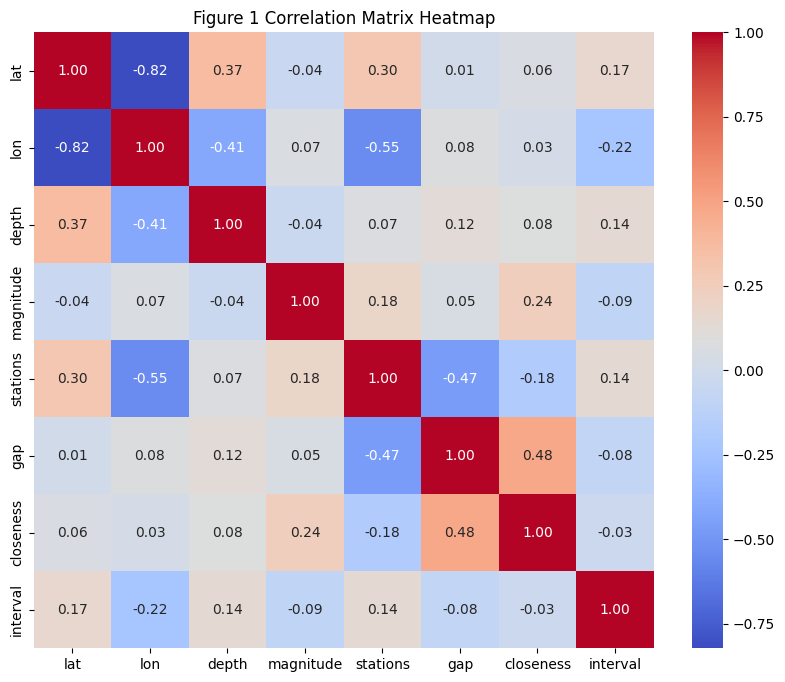

In [157]:
#select numerical features for correlation analysis
numerical_features = ['lat', 'lon', 'depth', 'magnitude', 'stations', 'gap', 'closeness', 'interval']
correlation_matrix = scaled_data[numerical_features].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Figure 1 Correlation Matrix Heatmap')
plt.show()

The correlation matrix heat map shows that there is no strong correlation between the measured earthquake detphs, magnitudes, closeness to the epicenters, etc.

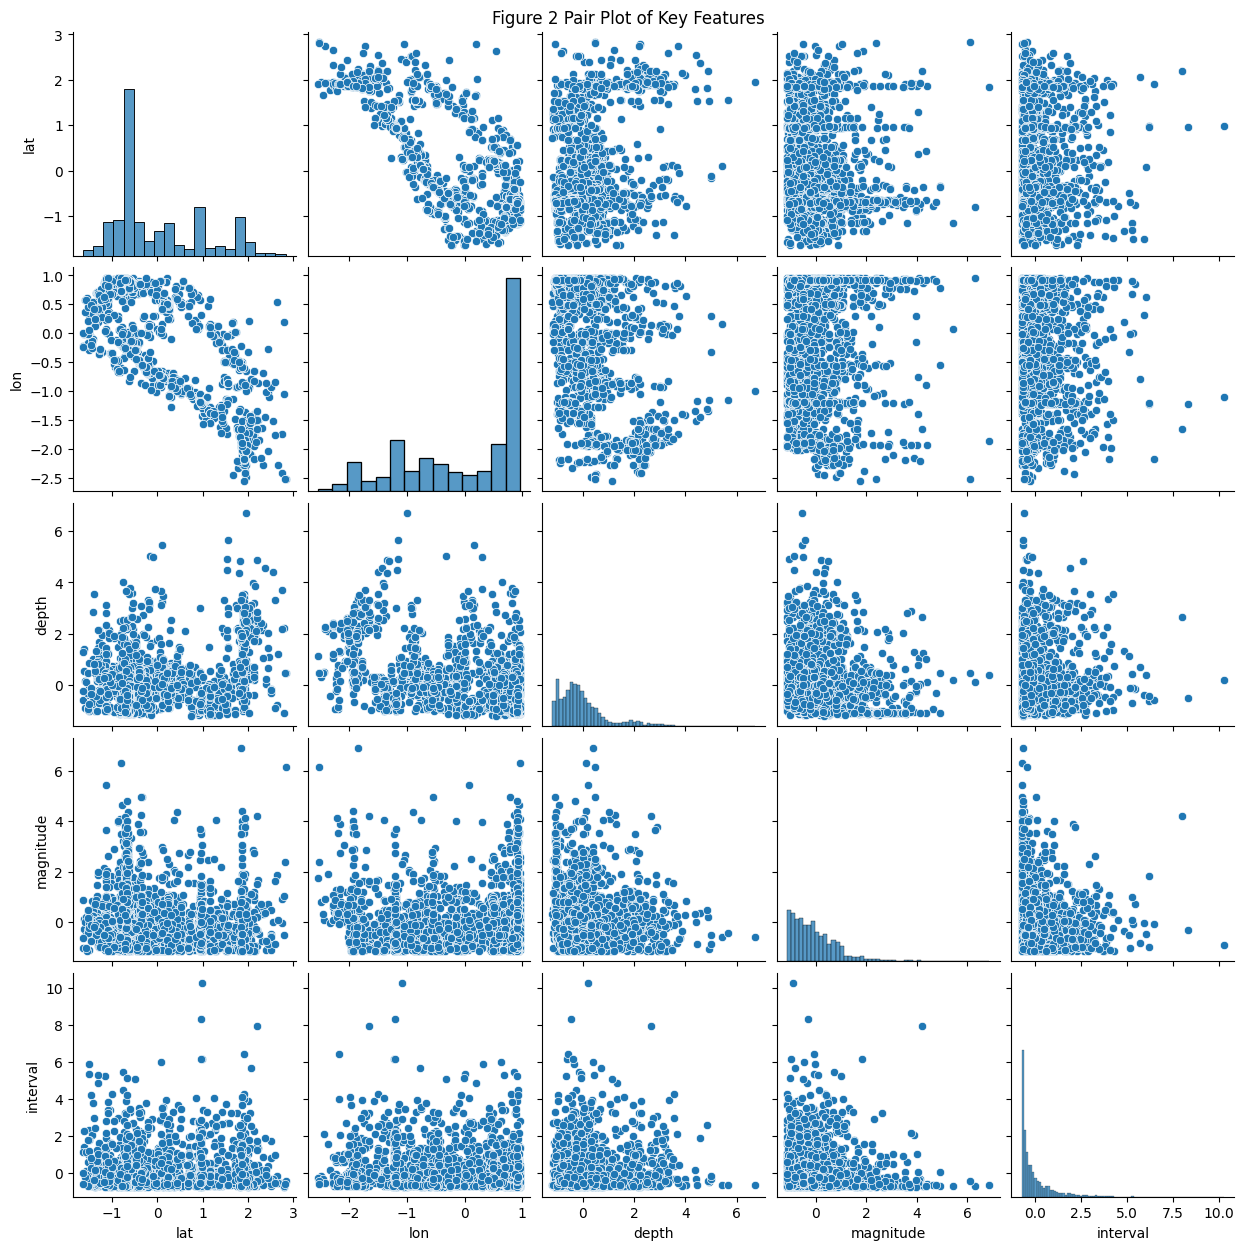

In [158]:
# create the pair plot with key features
key_features = ['lat', 'lon', 'depth', 'magnitude', 'interval']
sns.pairplot(scaled_data[key_features])
plt.suptitle('Figure 2 Pair Plot of Key Features', y=1)
plt.show()

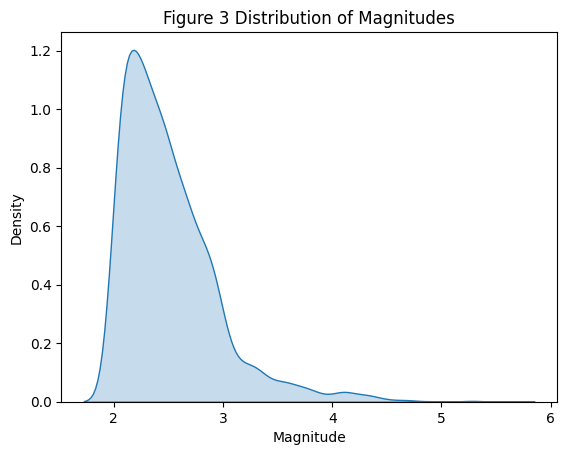

In [174]:
#density plot to show distribution of magnitudes
sns.kdeplot(data['magnitude'], fill=True)
plt.title('Figure 3 Distribution of Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Density')
plt.show()

This graph shows that the data is skewed to the right and that the majority of earthquakes recorded were between a magnitude of 2 and 3.

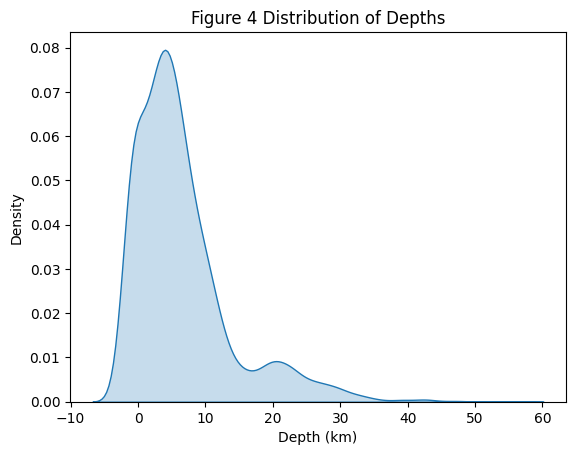

In [175]:
#density plot to show distribution of depths
sns.kdeplot(data['depth'], fill=True)
plt.title('Figure 4 Distribution of Depths')
plt.xlabel('Depth (km)')
plt.ylabel('Density')
plt.show()

This graph is skewed to the right and shows that the majority of earthquakes recorded occured at a depth between 0 and 10 km deep.

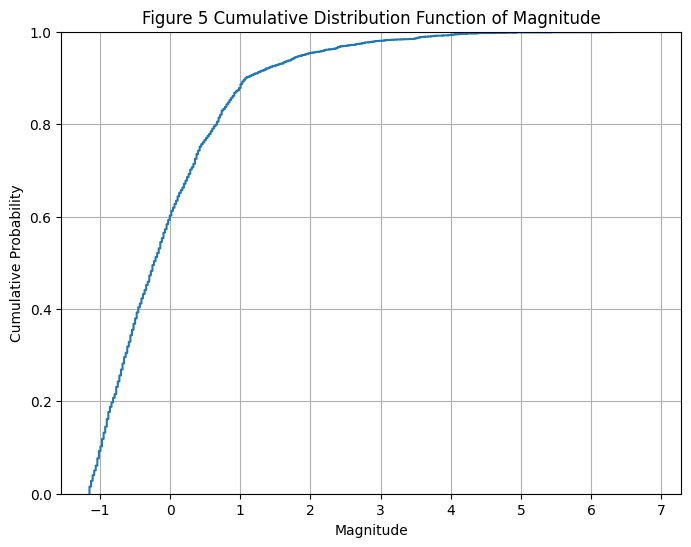

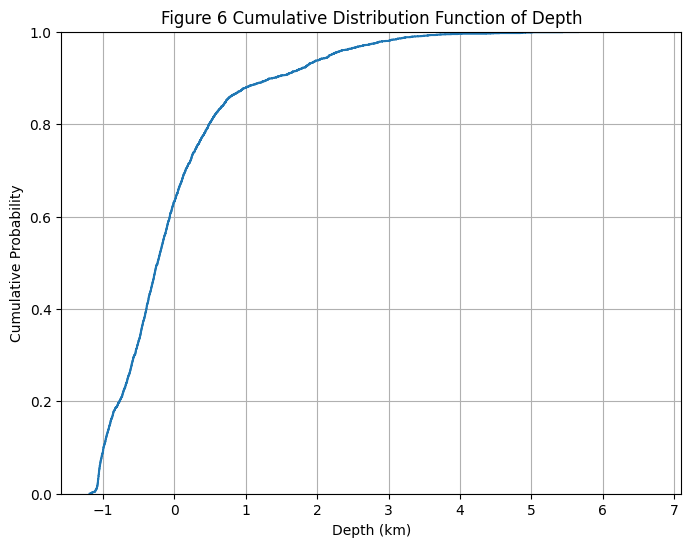

In [161]:
#create the CDF plot for magnitude
plt.figure(figsize=(8, 6))
sns.ecdfplot(scaled_data['magnitude'])
plt.title('Figure 5 Cumulative Distribution Function of Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

#create the CDF plot for depth
plt.figure(figsize=(8, 6))
sns.ecdfplot(scaled_data['depth'])
plt.title('Figure 6 Cumulative Distribution Function of Depth')
plt.xlabel('Depth (km)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

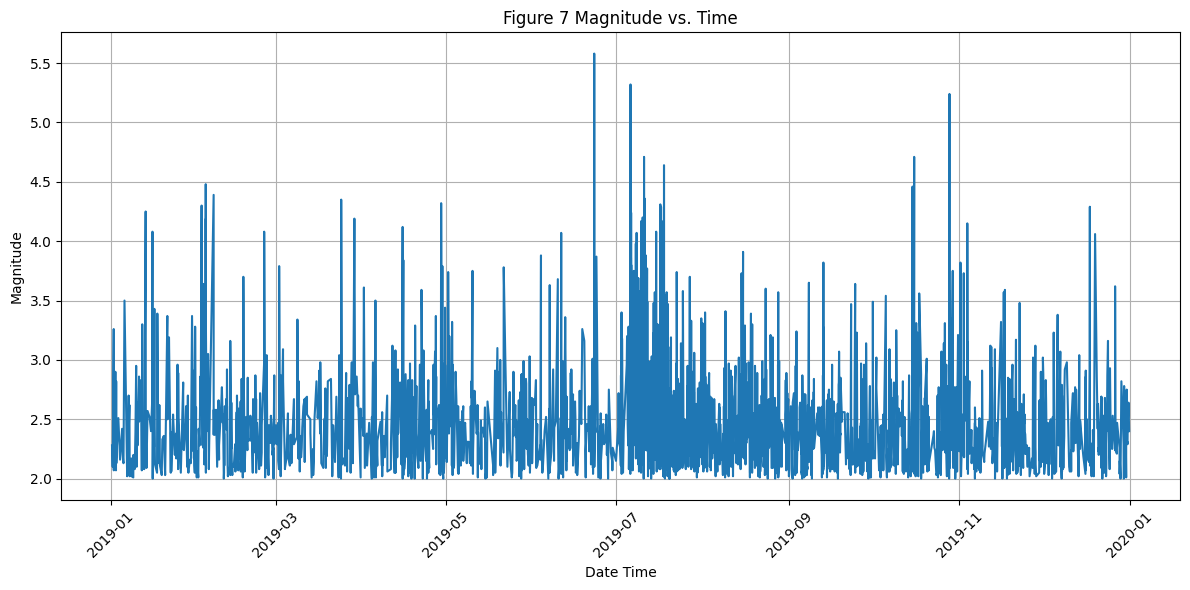

In [162]:
#plot magnitude vs. time using the original data DataFrame
plt.figure(figsize=(12, 6))
plt.plot(data['datetime'], data['magnitude'])
plt.xlabel('Date Time')
plt.ylabel('Magnitude')
plt.title('Figure 7 Magnitude vs. Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot shows the magnitude of earthquakes over the year 2019. It shows an increase in frequency and magnitude around the month of July.

Moving forward I hope to find if there is any correlation between time passed and likelihood of a repeat event.

#Unsupervised ML

## KMeans

Below shows the Kmeans clustering using the elbow method to determine the optimal number of clusters. It is followed by a plot that shows the three determined clusters and how the earthquakes measured in both depth and magnitude.

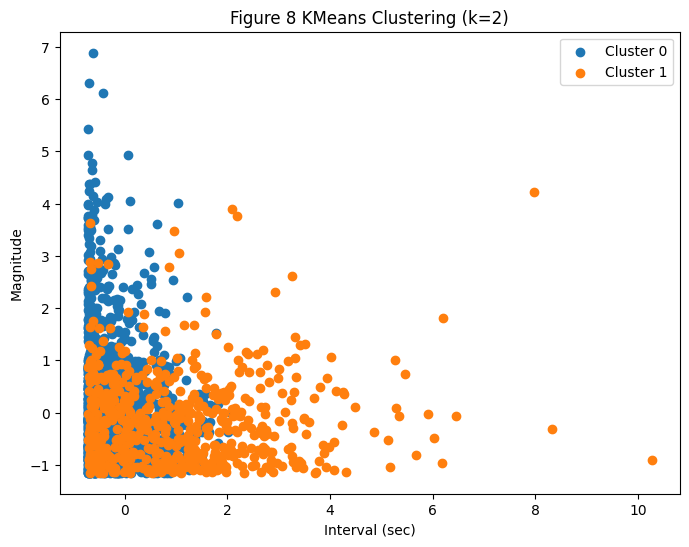

Optimal number of clusters based on Silhouette Score: 2
Silhouette Score for optimal k: 0.4111399694267218


In [163]:
# Create a new DataFrame with selected features for clustering
features = ['depth', 'magnitude', 'interval']
X = scaled_data[features]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Silhouette Score
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters with the highest Silhouette Score
optimal_k = np.argmax(silhouette_scores) + 2

# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
scaled_data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters (example with depth and magnitude)
plt.figure(figsize=(8, 6))
for cluster_label in range(optimal_k):
  cluster_data = scaled_data[scaled_data['cluster'] == cluster_label]
  plt.scatter(cluster_data['interval'], cluster_data['magnitude'], label=f'Cluster {cluster_label}')

plt.xlabel('Interval (sec)')
plt.ylabel('Magnitude')
plt.title(f'Figure 8 KMeans Clustering (k={optimal_k})')
plt.legend()
plt.show()

print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"Silhouette Score for optimal k: {silhouette_scores[optimal_k-2]}")

Figure 8 graphs the KMeans of the magnitude and interval. The score of 0.4 falls just bellow the 0.5 threshold of a "good" correlation.

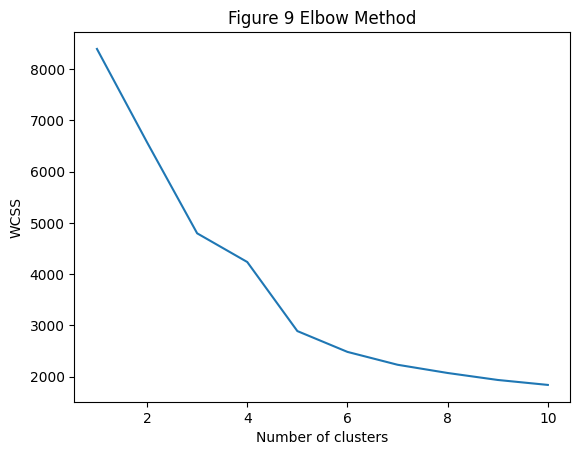

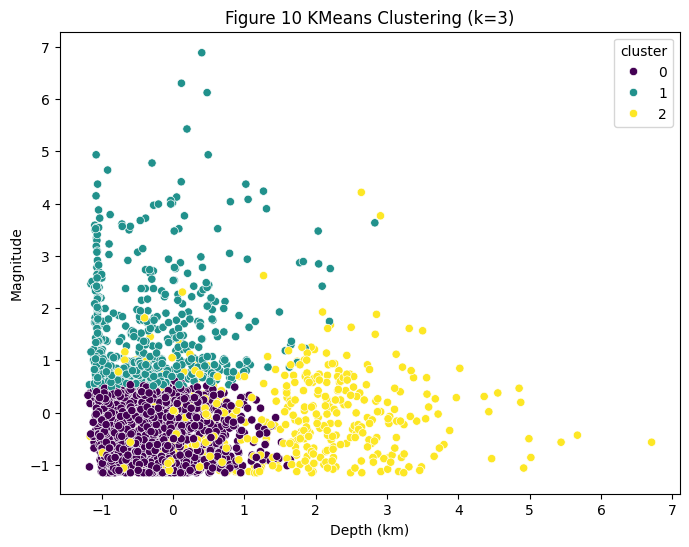

In [165]:
# Select features for clustering
features = ['depth', 'magnitude', 'interval']
X = scaled_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Figure 9 Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply KMeans clustering with the chosen number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
scaled_data['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=scaled_data, palette='viridis') # Changed data to scaled_data
plt.title(f'Figure 10 KMeans Clustering (k={optimal_k})')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

In [166]:
# Calculate Silhouette Score
score = kmeans.score(X_scaled)
print(f"KMeans score: {score}")

KMeans score: -4796.6260174136


Figure 10 shows the KMeans of depth and magnitude graphed against eachother. It has a very high negative KMeans score which indicates that there is no correlation.

## DBScan

Below shows the DBScan clustering method to determine the optimal number of clusters.

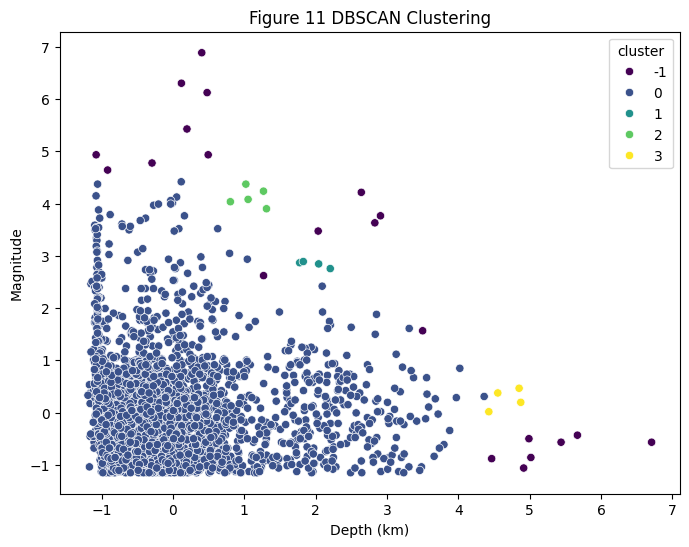

Silhouette Score: 0.5119889340614767


In [167]:
# Select features for clustering
features = ['depth', 'magnitude']
X = scaled_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
scaled_data['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=scaled_data, palette='viridis')
plt.title('Figure 11 DBSCAN Clustering')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = scaled_data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Figure 11 shows the DBScan of the depth and magnitude of the earthquake data. It recieved a silhouette score of about 0.5 which would indicate a "good" correlation.

In [169]:
# Get the number of clusters
n_clusters = len(set(scaled_data['cluster'])) - (1 if -1 in scaled_data['cluster'] else 0) # Subtract 1 for noise points if present

print(f"Number of clusters: {n_clusters}")

Number of clusters: 5


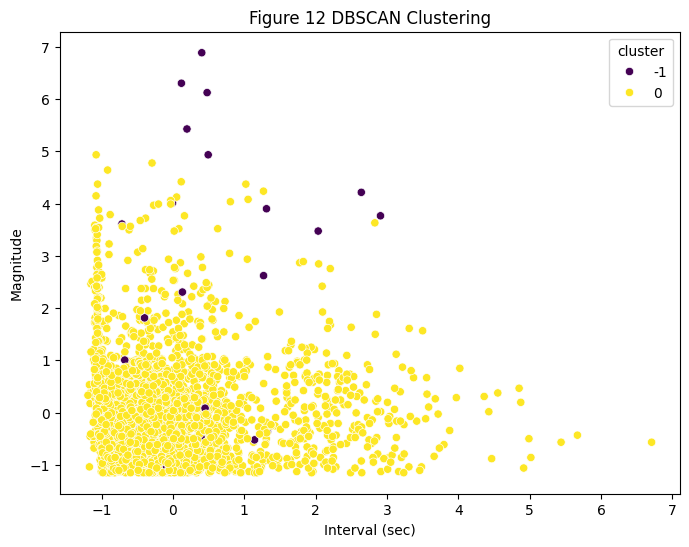

Silhouette Score: 0.7261682920971653


In [170]:
# Select features for clustering
features = ['interval', 'magnitude']
X = scaled_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
scaled_data['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=scaled_data, palette='viridis')
plt.title('Figure 12 DBSCAN Clustering')
plt.xlabel('Interval (sec)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = scaled_data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Figure 12 shows the DBScan of the interval and magnitude of the earthquake data. It recieved a silhouette score of about 0.73 which indicates a correlation between these variables.

## Gaussian Mixture

Below shows the Gaussian Mixture method of clustering.

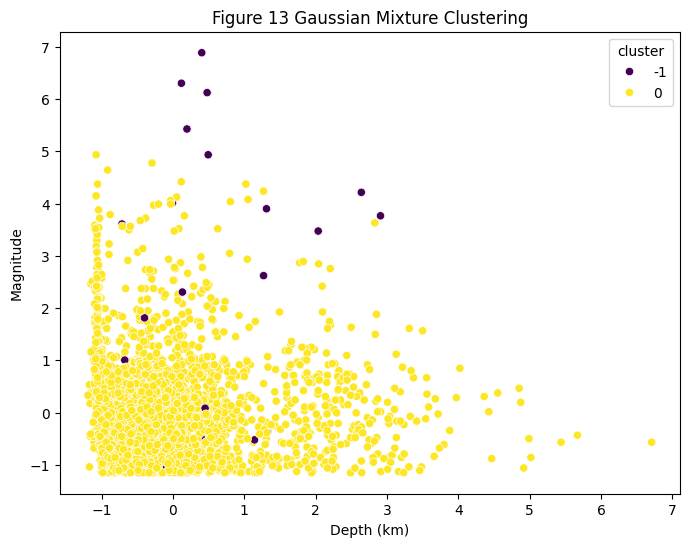

Silhouette Score: 0.4615623307275357


In [171]:
# Select features for clustering
features = ['depth', 'magnitude']
X = scaled_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Gaussian Mixture clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # You can adjust n_components
data['cluster'] = gmm.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='depth', y='magnitude', hue='cluster', data=scaled_data, palette='viridis')
plt.title('Figure 13 Gaussian Mixture Clustering')
plt.xlabel('Depth (km)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = scaled_data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Figure 13 shows the Gaussian Mixture of the depth and magnitude of the earthquake data. It recieved a silhouette score of about 0.46 which falls just bellow the 0.5 threshold of a "good" correlation.

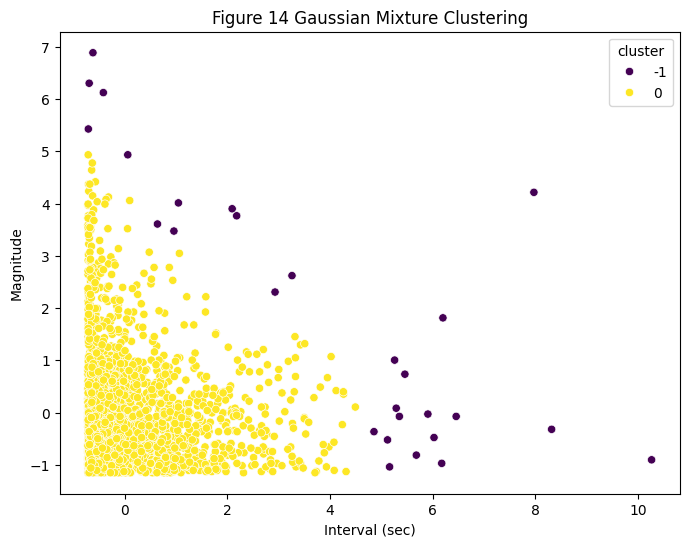

Silhouette Score: 0.7261682920971653


In [173]:
# Select features for clustering
features = ['interval', 'magnitude']
X = scaled_data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Gaussian Mixture clustering
gmm = GaussianMixture(n_components=3, random_state=42)  # You can adjust n_components
data['cluster'] = gmm.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='interval', y='magnitude', hue='cluster', data=scaled_data, palette='viridis')
plt.title('Figure 14 Gaussian Mixture Clustering')
plt.xlabel('Interval (sec)')
plt.ylabel('Magnitude')
plt.show()

# Calculate Silhouette Score
labels = scaled_data['cluster']
silhouette_avg = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette_avg}")

Figure 14 shows the Guassian Mixture of the interval and magnitude of the earthquake data. It recieved a silhouette score of about 0.73 which indicates a correlation between these variables.

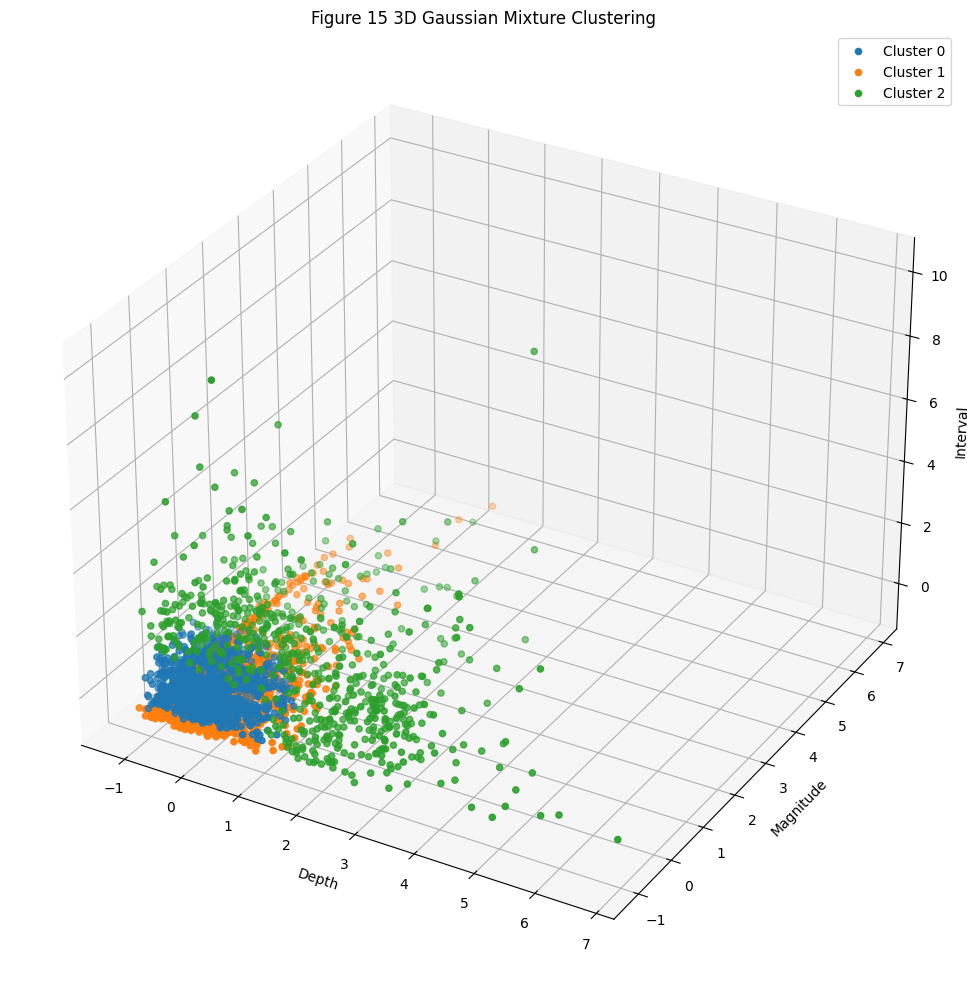

Silhouette Score: 0.09389476080110487


In [185]:
from mpl_toolkits.mplot3d import Axes3D

# Select features for clustering
features = ['depth', 'magnitude', 'interval']
X = scaled_data[features]

# Apply Gaussian Mixture clustering (example with 3 components)
gmm = GaussianMixture(n_components=3, random_state=42)
scaled_data['cluster'] = gmm.fit_predict(X)

# Create the 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster in range(3):
    cluster_data = scaled_data[scaled_data['cluster'] == cluster]
    ax.scatter(cluster_data['depth'], cluster_data['magnitude'], cluster_data['interval'], label=f'Cluster {cluster}')

ax.set_xlabel('Depth')
ax.set_ylabel('Magnitude')
ax.set_zlabel('Interval')
ax.set_title('Figure 15 3D Gaussian Mixture Clustering')
ax.legend()
fig.tight_layout()
plt.show()


# Calculate Silhouette Score
labels = scaled_data['cluster']
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

Figure 15 shows the Gaussian Mixture of depth, magnitude, and interval time plotted against one another. The silhouette score is very low of abut 0.09 meaning that there is no correlation between all three of these variables.

# Conclusion

Overall this data showed the in earthquakes recorded in Northern California in the year 2019 showed a slight correlation between the depth and magnitude of earthquakes. A slightly stronger correlation was found between magnitude and the interval time between earthquakes. This tells us that the more time that passes between earthquakes and the shallower the eaerthquake, than the more likely it is that the earthquake will be higher in magnitude. This data would suggest that if there are large periods of time between earthquakes then people in Northern California should better prepare themselves for an upcoming earthquake with high magnitude.

# Write up questions

### Which method did you like the best?

I liked the Guassian Mixture and KMeans method the best as I felt it was visually easier to see the clusters and the clusters chosen made more sense to me logically.

### Which method did you like the least?

I did not like the DBScan method as much as the other two because I found it very difficult to determine how the clusters where formed or even to visually determine where the clusters fell.

### How did you score these unsupervised models?

I used a mixture of kmeans scoring and silhouette scoring. I used the KMeans score on the KMeans clustering which returned a large negative number indicating the clustering was poor. For the DSBcan and the Guassian Mixture I used silhouette scoring both of which returned a score close to or above 0.5 which falls within the range of a "good" cluster when comparing depth and magnitude.

### Did the output align with your geologic understanding?

In general the output aligned with my geologic understanding as shallower earthquakes tend to have higher magnitudes and deeper earthquakes have lower magnitudes. This was shown in the clustering of all three methods used. The data also showed a correlation between magnitude and interval time. This makes sense because Northern California is on a slip fault so it would make sense that the more time that passes between earthquakes the more the fault slips, therefore creating a higher magnitude earthquake.

### What did you want to learn more about?

I would like to learn more about how the methods I used are different from one another as they produced realtively similar models/results. I would like to learn more about if this is due to the nature of my dataset, user error, or if I just happened to pick methods that have similar outputs.

### Did you pre-process your data?

I did some preprocessing by coverting the time and date columns into a datetime column and then using that to create and interval column which calculates the time in seconds between recorded events. I also made sure to remove any missing data.

### What was a decision you were most unsure about?

As I am new to unsupervised methods I felt unsure about if I was using the correct methods, features, and if I was using the correct plots to visualize my data. Moving forward I would like to spend more time with the different unsupervised methods inorder learn which method truely works best for my dataset. I would also like to try different types of plots to visualize my clustering methods to determine which plots best show my data.